In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nibabel as nib #for loading nii files
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf #for deep learning
import os
import glob


rel_path = "data/COVID-19_Lung_CT_Scan/"

data = pd.read_csv(rel_path + 'metadata.csv')

def read_nii(filepath):
    print(filepath)
    ct_scan = nib.load(filepath)
    array = ct_scan.get_fdata()
    array = np.rot90(np.array(array))
    return(array)

# Read sample
print("Reading samples...")
sample_ct   = read_nii(glob.glob(rel_path + "ct_scans/*.nii")[0])
sample_lung = read_nii(glob.glob(rel_path + "lung_mask/*.nii")[0])
sample_infe = read_nii(glob.glob(rel_path + "infection_mask/*.nii")[0])
sample_all  = read_nii(glob.glob(rel_path + "lung_and_infection_mask/*.nii")[0])

Reading samples...
data/COVID-19_Lung_CT_Scan/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii
data/COVID-19_Lung_CT_Scan/lung_mask/radiopaedia_7_85703_0.nii
data/COVID-19_Lung_CT_Scan/infection_mask/radiopaedia_7_85703_0.nii
data/COVID-19_Lung_CT_Scan/lung_and_infection_mask/radiopaedia_7_85703_0.nii


'../input/covid19-ct-scans/ct_scans/coronacases_org_002.nii'

In [18]:
lungs = []
infections = []
img_size = 128

print("Reading images and resizing...")
ct_paths = glob.glob(rel_path + "ct_scans/*.nii")
infection_mask_paths = glob.glob(rel_path + "infection_mask/*.nii")
for i in range(len(data)):
    ct = read_nii(ct_paths[i])
    infect = read_nii(infection_mask_paths[i])
    for ii in range(ct.shape[0]):
        try:
            lung_img = cv2.resize(ct[ii], dsize = (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')
            infec_img = cv2.resize(infect[ii], dsize = (img_size, img_size), interpolation = cv2.INTER_AREA).astype('uint8')
            lungs.append(lung_img[..., np.newaxis])
            infections.append(infec_img[..., np.newaxis])
        except:
            continue

lungs = np.array(lungs)
infections = np.array(infections)

Reading images and resizing...
data/COVID-19_Lung_CT_Scan/ct_scans/radiopaedia_org_covid-19-pneumonia-10_85902_1-dcm.nii
data/COVID-19_Lung_CT_Scan/infection_mask/radiopaedia_7_85703_0.nii
data/COVID-19_Lung_CT_Scan/ct_scans/radiopaedia_org_covid-19-pneumonia-4_85506_1-dcm.nii
data/COVID-19_Lung_CT_Scan/infection_mask/radiopaedia_4_85506_1.nii
data/COVID-19_Lung_CT_Scan/ct_scans/radiopaedia_org_covid-19-pneumonia-7_85703_0-dcm.nii
data/COVID-19_Lung_CT_Scan/infection_mask/radiopaedia_40_86625_0.nii
data/COVID-19_Lung_CT_Scan/ct_scans/radiopaedia_org_covid-19-pneumonia-40_86625_0-dcm.nii
data/COVID-19_Lung_CT_Scan/infection_mask/radiopaedia_36_86526_0.nii
data/COVID-19_Lung_CT_Scan/ct_scans/radiopaedia_org_covid-19-pneumonia-36_86526_0-dcm.nii
data/COVID-19_Lung_CT_Scan/infection_mask/radiopaedia_29_86491_1.nii
data/COVID-19_Lung_CT_Scan/ct_scans/radiopaedia_org_covid-19-pneumonia-29_86490_1-dcm.nii
data/COVID-19_Lung_CT_Scan/infection_mask/radiopaedia_29_86490_1.nii
data/COVID-19_Lung_

In [19]:
from sklearn.model_selection import train_test_split
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size = 0.1)

#Build the model
print("Creating model...")

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 1

inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
  
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
   
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
      
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
       
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Creating model...


2021-10-22 14:02:02.730621: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-22 14:02:02.730989: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-10-22 14:02:02.732172: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [20]:
print("Training model...")
with tf.device('/device:cpu:0'):
    history = model.fit(lung_train, infect_train, epochs = 2, validation_data = (lung_test, infect_test))



Training model...
Epoch 1/2


2021-10-22 14:02:10.660042: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


312/312 [==============================] - 314s 998ms/step - loss: 0.0561 - accuracy: 0.9903 - val_loss: 0.0364 - val_accuracy: 0.9927
Epoch 2/2
312/312 [==============================] - 303s 970ms/step - loss: 0.0305 - accuracy: 0.9929 - val_loss: 0.0307 - val_accuracy: 0.9927


(1108, 128, 128, 1)


Text(0.5, 1.0, 'predicted infection mask')

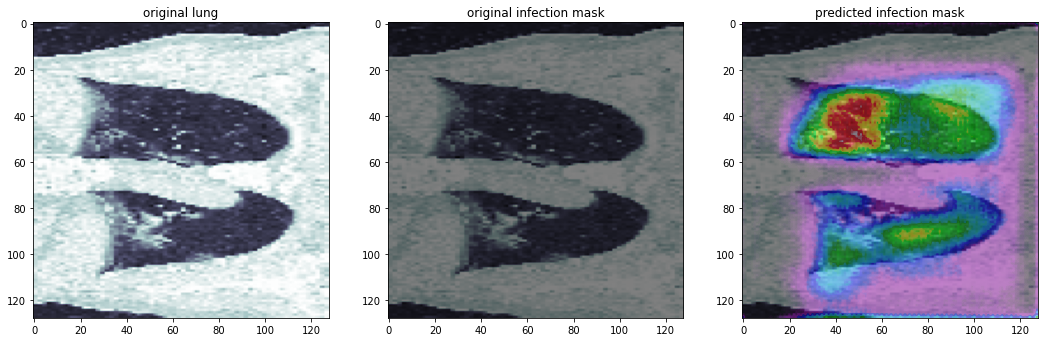

In [33]:
predicted = model.predict(lung_test)
print(predicted.shape)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(lung_test[100][...,0], cmap = 'bone')
plt.title('original lung')

plt.subplot(1,3,2)
plt.imshow(lung_test[100][...,0], cmap = 'bone')
plt.imshow(infect_test[100][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(lung_test[100][...,0], cmap = 'bone')
plt.imshow(predicted[100][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

In [49]:
#print(data.loc[1,'ct_scan'])
s_ct = read_nii(rel_path + "ct_scans/coronacases_org_002.nii")

data/COVID-19_Lung_CT_Scan/ct_scans/coronacases_org_002.nii


In [50]:
print(data.loc[1,'lung_mask'])
s_l = read_nii(rel_path + "lung_mask/coronacases_002.nii")

../input/covid19-ct-scans/lung_mask/coronacases_002.nii
data/COVID-19_Lung_CT_Scan/lung_mask/coronacases_002.nii


In [51]:
#print(data.loc[1,'infection_mask'])
s_i = read_nii(rel_path + "infection_mask/coronacases_002.nii")

data/COVID-19_Lung_CT_Scan/infection_mask/coronacases_002.nii


In [52]:
#print(data.loc[1,'lung_and_infection_mask'])
s_a  = read_nii(rel_path + "lung_and_infection_mask/coronacases_002.nii")

data/COVID-19_Lung_CT_Scan/lung_and_infection_mask/coronacases_002.nii


Text(0.5, 1.0, 'Lung and Infection Mask')

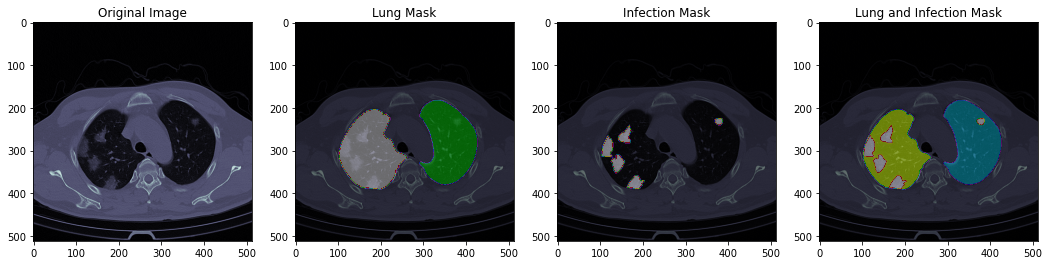

In [54]:
fig = plt.figure(figsize = (18,15))

plt.subplot(1,4,1)
plt.imshow(s_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(s_ct[..., 150], cmap = 'bone')
plt.imshow(s_l[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(s_ct[..., 150], cmap = 'bone')
plt.imshow(s_i[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(s_ct[..., 150], cmap = 'bone')
plt.imshow(s_a[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')